In [2]:
import jax
import jax.numpy as jnp
from jax.numpy.linalg import slogdet
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.projection_vi.utils import sample_ortho

In [3]:
def get_kl(mu1, Sigma1, mu2, Sigma2):
    """
    KL divergence between N(mu1, Sigma1) and N(mu2, Sigma2)
    """
    Sigma2_inv = jnp.linalg.inv(Sigma2)
    Sigma2_inv_Sigma1 = Sigma2_inv @ Sigma1
    mu_diff = mu2 - mu1
    return 0.5 * (
        jnp.trace(Sigma2_inv_Sigma1) +
        mu_diff @ Sigma2_inv @ mu_diff -
        len(mu1) +
        -slogdet(Sigma2_inv_Sigma1)[1]
    )

def optimal_mf(mu, Sigma):
    """
    optimal mean-field gaussian approximation of N(mu, Sigma)
    """
    Sigma_inv = jnp.linalg.inv(Sigma)
    return mu, 1 / jnp.diag(Sigma_inv)

## Number of iterations needed to achieve $\epsilon$ KL

In [4]:
eps = 0.01

def num_iter_needed_random_rotation(d, kappa):
    mu = jnp.zeros(d)
    nu_list = jnp.linspace(1, kappa, d)
    nu_list /= jnp.mean(nu_list)
    Sigma = jnp.diag(1 / nu_list)

    key = jax.random.key(0)
    max_iter = 1000
    nrep = 30
    Sigma_ks = jnp.stack([Sigma] * nrep, axis=0)
    keys = jax.random.split(key, nrep)
    @jax.jit
    def one_step(Sigma_k, key):
        key, subkey = jax.random.split(key)
        R = sample_ortho(d, subkey)
        Sigma_R = R @ Sigma_k @ R.T
        _, Sigma_q = optimal_mf(mu, Sigma_R)
        kl = get_kl(mu, jnp.diag(Sigma_q), mu, Sigma_R)
        return jnp.diag(1 / jnp.sqrt(Sigma_q)) @ Sigma_R @ jnp.diag(1 / jnp.sqrt(Sigma_q)), key, kl

    for i in range(max_iter):
        Sigma_ks, keys, kls = jax.vmap(one_step, in_axes=(0, 0), out_axes=(0, 0, 0))(Sigma_ks, keys)
        if kls.mean() <= eps:
            break
    if kls.mean() > eps:
        print(f"Warning: did not converge in {max_iter} iterations")    
    return i

def num_iter_needed_pca(d, kappa):
    def one_step(Sigma):
        d = Sigma.shape[0]
        mu = jnp.zeros(d)
        H_bar = jnp.linalg.inv(Sigma) - jnp.eye(d)
        nus, eigvecs = jnp.linalg.eigh(H_bar)
        sorted_idx = jnp.argsort(nus**2)[::-1]
        r = jnp.where(jnp.cumsum(nus[sorted_idx]**2) >= 0.5 * jnp.sum(nus**2))[0][0] + 1
        V_r = eigvecs[:, sorted_idx[:r]]
        V = jnp.linalg.qr(V_r, 'complete')[0]
        Sigma_R = V.T @ Sigma @ V

        Sigma_q = optimal_mf(mu, Sigma_R)[1]

        kl = get_kl(mu, jnp.diag(Sigma_q), mu, Sigma_R)
        return jnp.diag(1 / jnp.sqrt(Sigma_q)) @ Sigma_R @ jnp.diag(1 / jnp.sqrt(Sigma_q)), kl

    def run(d, kappa, key):
        mu = jnp.zeros(d)
        nu_list = jnp.linspace(1, kappa, d)
        nu_list /= jnp.mean(nu_list)
        Sigma = jnp.diag(1 / nu_list)
        R = sample_ortho(d, key)
        Sigma = R @ Sigma @ R.T
        
        max_iter = 10
        kl_logs = []
        for i in range(max_iter):
            Sigma, kl = one_step(Sigma)
            kl_logs.append(kl)
        return kl_logs
    
    nrep = 30
    keys = jax.random.split(jax.random.key(0), nrep)
    kl_logs = [run(d, kappa, key) for key in keys]
    return int(jnp.where(jnp.array(kl_logs).mean(0) <= eps)[0][0])

In [5]:
# vary d
d_list = [10, 20, 30, 40, 50]
kappa_list = [10, 20, 30, 40, 50]
num_iters = {}
for d in d_list:
    for kappa in kappa_list:
        print(d, kappa)
        num_iters[('random', d, kappa)] = num_iter_needed_random_rotation(d, kappa)
        num_iters[('pca', d, kappa)] = num_iter_needed_pca(d, kappa)

10 10
10 20
10 30
10 40
10 50
20 10
20 20
20 30
20 40
20 50
30 10
30 20
30 30
30 40
30 50
40 10
40 20
40 30
40 40
40 50
50 10
50 20
50 30
50 40
50 50


In [6]:
df = pd.DataFrame(num_iters, index=['n']).T.reset_index(names=['rotation', 'dim', 'kappa'])

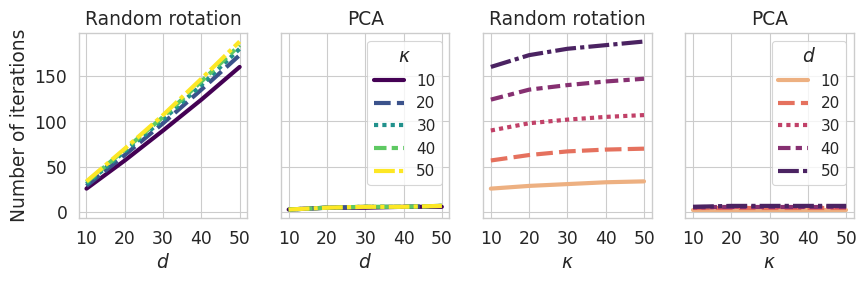

In [7]:
sns.set_theme(context='paper', style='whitegrid', font_scale=1.4)
fig, ax = plt.subplots(1, 4, figsize=(10, 2.4), sharey=True)
sns.lineplot(ax=ax[0], data=df.loc[df['rotation'] == 'random'], x='dim', y='n', hue='kappa', palette='viridis', style='kappa', lw=3)
ax[0].set_xlabel(r'$d$')
ax[0].legend().remove()
ax[0].set_title('Random rotation')
ax[0].set_ylabel('Number of iterations')
ax[0].set_xticks(d_list)

sns.lineplot(ax=ax[1], data=df.loc[df['rotation'] == 'pca'], x='dim', y='n', hue='kappa', palette='viridis', style='kappa', lw=3)
ax[1].set_xlabel(r'$d$')
ax[1].legend(title=r'$\kappa$', fontsize=11, loc='upper right')
ax[1].set_title('PCA')
ax[1].set_ylabel('Number of iterations')
ax[1].set_xticks(d_list)

sns.lineplot(ax=ax[2], data=df.loc[df['rotation'] == 'random'], x='kappa', y='n', hue='dim', palette='flare', style='dim', lw=3)
ax[2].set_xlabel(r'$\kappa$')
ax[2].set_title('Random rotation')
ax[2].set_xticks(kappa_list)
ax[2].legend().remove()

sns.lineplot(ax=ax[3], data=df.loc[df['rotation'] == 'pca'], x='kappa', y='n', hue='dim', palette='flare', style='dim', lw=3)
ax[3].set_xlabel(r'$\kappa$')
ax[3].set_title('PCA')
ax[3].set_xticks(kappa_list)
ax[3].legend(title=r'$d$', fontsize=11, loc='upper right')

# plt.savefig('experiments/plots/gaussian_random_vs_pca.pdf', bbox_inches='tight')